**Finite Elements: Homework 1**

Bernardo Caprile\
Pedro Valenzuela

Below is the implemented code for the 2D structure presented in Homework 1. Each step of the implementation is explained clearly.

In this first cell, the necessary classes are imported, along with mathematical and plotting tools.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from elementclass import Element
from nodeclass import Node
from structuresolver import StructureSolver

Luego se definen las funciones que plotearan los elemnetos y como estos se deforman

In [2]:
def plotElement(self, ax=None, color='b', text=False):
    """
    Dibuja el elemento como una línea entre sus nodos.
    """
    if ax is None:
        fig, ax = plt.subplots()

    xi, yi = self.node_i.coordenadas
    xj, yj = self.node_j.coordenadas

    ax.plot([xi, xj], [yi, yj], color + '-', linewidth=2)

    return ax
def plot_deformed_elements(elementos, ax=None, scale_factor=1):
    if ax is None:
        fig, ax = plt.subplots()

    for elem in elementos:
        xi, yi = elem.node_i.coordenadas
        xj, yj = elem.node_j.coordenadas

        # Calculamos los desplazamientos deformados escalados
        delta_xi = desplazamientos[elem.node_i.idx[0]]  # Desplazamiento nodo i en X
        delta_yi = desplazamientos[elem.node_i.idx[1]]  # Desplazamiento nodo i en Y
        delta_xj = desplazamientos[elem.node_j.idx[0]]  # Desplazamiento nodo j en X
        delta_yj = desplazamientos[elem.node_j.idx[1]]  # Desplazamiento nodo j en Y

        # Aplicamos el factor de escala solo a las deformaciones
        xi_deformed = xi + delta_xi * scale_factor
        yi_deformed = yi + delta_yi * scale_factor
        xj_deformed = xj + delta_xj * scale_factor
        yj_deformed = yj + delta_yj * scale_factor

        # Graficamos el elemento deformado como una línea entre los nodos deformados
        ax.plot([xi_deformed, xj_deformed], [yi_deformed, yj_deformed], 'r-', linewidth=2)  # Barra deformada

    return ax

Se definen los parametros iniciales del problema


In [3]:

globalParameters = {'nDoF': 3}  
E = 200000000  # Módulo de elasticidad
Espaciado = 9.14 #metros
a = 3.96 / 2#metros
b = 3.96#metros
Alt_cs = [11.13, 19.05, 26.97, 34.89]#metros
Altura = [0, 3.66, 5.49, a, a, b, a, a, b, a, a, b, a, a, b]#metros
ql = 26 #kN

Como a lo largo del edificio hay cambios de secciones, aqui se definen las inercias y las areas de estas

In [4]:
A_ce=[0.070322, 0.070322, 0.053742, 0.048774, 0.044193]#metros cuadrados
I_ce=[2.2643e-3, 2.2643e-3, 1.598e-3, 1.415e-3, 1.2529e-3]#metros cuadrados
A_cc=[0.094839, 0.086451, 0.070322, 0.053742, 0.048774]#metros cuadrados
I_cc=[3.417e-3, 2.993e-3, 2.2643e-3, 1.598e-3, 1.415e-3]#metros cuadrados

A_v=[0.030323, 0.030323, 0.022064, 0.012968]#metros cuadrados
I_v=[4.0624e-3, 4.0624e-3, 2.052e-3, 7.617e-4]#metros cuadrados



En esta celda se calcula el peso propio de la estructura, para poder responde las preguntas 2 y 3

In [5]:
def calcular_carga_peso():
    q_peso = 0
    altidx = 0
    cont1 = 0
    densidad = 7800/1000*9.81  # kN/m^3 (2.5 Ton/m³ * 9.81 para convertir a kN/m³)

    for i in range(len(Altura) - 1):
        altidx += Altura[i]
        
        for j in range(6):
            k = i * 6 + j
            if any(np.isclose(altidx, val) for val in Alt_cs):
                if j == 0:
                    cont1 += 1
            
            # Calcular para columnas
            if j == 0 or j == 5:
                A1 = A_ce[cont1]  # Área de la columna
                Longitud = Altura[i+1] - Altura[i]  # Longitud del piso
                q_peso += A1 * Longitud * densidad  # Peso de la columna
            else:
                A2 = A_cc[cont1]  # Área para otras columnas
                Longitud = Altura[i+1] - Altura[i]  # Longitud del piso
                q_peso += A2 * Longitud * densidad  # Peso de otras columnas
            
            # Crear vigas solo si NO hay cambio de sección
            if j < 5 and i != 0 and not any(np.isclose(altidx, val) for val in Alt_cs):
                if i % 2 == 0 and i > 3:
                    A = A_v[3]  # Área de la viga
                    q_peso += A * Espaciado * densidad  # Peso de la viga
                elif i == 1:
                    A = A_v[0] 
                    q_peso += A * Espaciado * densidad
                elif i == 2:
                    A = A_v[1] 
                    q_peso += A * Espaciado * densidad
                elif i % 2 == 1 and i > 3:
                    A = A_v[2] 
                    q_peso += A * Espaciado * densidad
    
    # Agregar el peso para el último piso horizontal
    for j in range(5):
        A = A_v[3]
        q_peso += A * Espaciado * densidad  # Peso de la última viga
    
    return q_peso

Luego al tener una  carga viva aplicada, se suma con la carga muerta del peso propio para asi llevarlo a una sola carga

In [6]:
def calcular_carga(i, alt, ql):
    if i % 2 == 0 and i > 3:
        A = A_v[3] 
        qd = A * Espaciado * 2.5
        if alt == 40.83:
            ql = 23.1
        q = ql + qd
    elif i == 1:
        A = A_v[0] 
        qd = A * Espaciado * 2.5
        q = ql + qd
    elif i == 2:
        A = A_v[1] 
        qd = A * Espaciado * 2.5
        q = ql + qd
    elif i % 2 == 1 and i > 3:
        A = A_v[2] 
        qd = A * Espaciado * 2.5
        q = ql + qd
    else:
        q = 0
    return q

En este caso la carga triangular distribuida se debe descomponer, por lo que se generan muchos momentos, asi que se implemento una funcion para calcular estos.

In [7]:
#Función crear cargas caso 3
def cargas_caso3(q_peso0, q_peso1, q_peso2, L1, L2, q, i):
    if i==0 or i==1:
            momento=0
            cortante=0
    else:
    # Ajuste de la carga
            c1 = q_peso0 * L1 / 2 + q_peso1 * L2 / 2
            c2 = 7 * (q_peso1 - q_peso0) / 20 + 3 * (q_peso2 - q_peso1) / 20
            cortante = c1 + c2
            
            # Ajuste para el momento
            m1 = -q_peso0 * L1**2 / 12 + q_peso1 * L2**2 / 12 + q * Espaciado**2 / 12
            m2 = -(q_peso1 - q_peso0) * L1**2 / 30 + (q_peso2 - q_peso1) * L2 / 20
            momento = m1 + m2
    
    # Asegúrate de que la carga y el momento estén en las unidades correctas (kN)
    return momento, cortante

En esta estrcutura hay un total de 90 nodos, donde los nodos de las reacciones tienen distintas restricciones que los otros nodos, por lo que se define como es cada uno y se implementa en una funcion.

In [8]:
def crear_nodos(caso):
    nodos = []
    alt = 0
    if caso == 1:
        for i, h in enumerate(Altura):
            alt += h
            for j in range(6):
                k = i * 6 + j
                restriccion = ['r', 'r', 'f'] if i == 0 or i==1 and (j==0 or j==5) else ['f', 'f', 'f']
                
                q = calcular_carga(i, alt, ql)
                
                if j == 0:
                    load = [0, -q * Espaciado / 2, q * Espaciado ** 2 / 12] 
                elif j == 5:
                    load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
                else:
                    load = [0, -q * Espaciado, 0]
                
                nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
                nodos.append(nodo)
    
    elif caso == 2:
        for i in range(len(Altura) - 1):
            alt += Altura[i]
            for j in range(6):
                k = i * 6 + j
                restriccion = ['r', 'r', 'f'] if i == 0 or i==1 and (j==0 or j==5) else ['f', 'f', 'f']
                
                q = calcular_carga(i, alt, ql)
                q_peso = calcular_carga_peso()*0.5/sum(Altura)  # Carga adicional por peso
                L = Altura[i+1] - Altura[i]  # Longitud del piso
                if j == 0:
                    load = [q_peso * L / 2, -q * Espaciado / 2, q * Espaciado ** 2 / 12] 
                elif j == 5:
                    load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
                else:
                    load = [0, -q * Espaciado, 0]
                
                nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
                nodos.append(nodo)

        # Aquí se agregan los nodos adicionales para conectar los últimos pisos horizontalmente
        for j in range(6):
            alt = sum(Altura)  # Utiliza la altura total acumulada
            k = (len(Altura) - 1) * 6 + j
            restriccion = ['f', 'f', 'f']
            q = calcular_carga(i, alt, ql)
            q_peso = calcular_carga_peso()*0.5/sum(Altura)
            L = Altura[i+1] - Altura[i]
            if j == 0:
                load = [q_peso * L / 2, -q * Espaciado / 2, q * Espaciado ** 2 / 12 - q_peso * L ** 2 / 12] 
            elif j == 5:
                load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
            else:
                load = [0, -q * Espaciado, 0]
            
            nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
            nodos.append(nodo)
    elif caso == 3:
        # Cálculo de las cargas de peso por planta
        carga = []
        alt = 0
        alt_q = 0.5*calcular_carga_peso() / (sum(Altura)-Altura[1])  # Ajuste de la carga
        for i in Altura:
            alt += i
            q_peso = alt_q * alt
            carga.append(q_peso)
            
        alt = 0  # Resetear la altura

        # Carga y momento para el caso 3
        for i in range(len(Altura) - 1):  # Ahora iteramos de 0 a len(Altura)-1
            alt += Altura[i]
            for j in range(6):
                k = i * 6 + j
                restriccion = ['r', 'r', 'f'] if i == 0 or i==1 and (j==0 or j==5) else ['f', 'f', 'f']
                
                q = calcular_carga(i, alt, ql)
                q_peso0 = carga[i - 1] if i > 0 else 0  # Carga del piso anterior
                q_peso1 = carga[i] 
                q_peso2 = carga[i + 1] 
                L1 = Altura[i] - Altura[i - 1] if i > 0 else Altura[i]  # Longitud entre pisos
                L2 = Altura[i + 1] - Altura[i]  # Longitud entre pisos
                
                # Calcular momento y cortante con la función personalizada
                momento, cortante = cargas_caso3(q_peso0, q_peso1, q_peso2, L1, L2, q, i)
                
                if j == 0:  # Aquí se aplica la carga triangular en las columnas
                    load = [cortante, -q * Espaciado / 2, momento]  # Carga para el nodo de la columna con carga triangular
                elif j == 5:
                    load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
                else:
                    load = [0, -q * Espaciado, 0]
                
                nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
                nodos.append(nodo)

        # Aquí se agregan los nodos adicionales para conectar los últimos pisos horizontalmente
        alt = sum(Altura)  # Calcular la altura total de la estructura
        for j in range(6):
            k = (len(Altura) - 1) * 6 + j
            restriccion = ['f', 'f', 'f']
            q = calcular_carga(i, alt, ql)
            q_peso0 = carga[-2]  # Carga del penúltimo piso
            q_peso1 = carga[-1]  # Carga del último piso
            q_peso2 = 0  # No hay carga adicional en el último nodo
            L1 = alt - Altura[-1]  # Longitud desde el último piso
            L2 = 0  # No hay longitud adicional para el último nodo
            momento, cortante = cargas_caso3(q_peso0, q_peso1, q_peso2, L1, L2, q, i)
            
            if j == 0:
                load = [cortante, -q * Espaciado / 2, momento]  # Carga para el nodo de la columna con carga triangular
            elif j == 5:
                load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
            else:
                load = [0, -q * Espaciado, 0]
            
            nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
            nodos.append(nodo)

    return nodos

Como antes se menciono hay cambios de seccion, por lo que se crean los leemntos y se define su inercia y area

In [9]:
def crear_elementos(nodos, dx):
    elementos = []
    altidx = 0
    cont1 = 0

    for i in range(len(Altura) - 1):
        altidx += Altura[i]
        
        for j in range(6):
            k = i * 6 + j
            if any(np.isclose(altidx, val) for val in Alt_cs):
                if j == 0:
                    cont1 += 1
            
            # Verificar que no estemos fuera del rango de nodos
            if k + 6 < len(nodos):  # Verifica que k + 6 esté dentro de los índices válidos
                # Crear elementos de columna
                if j == 0 or j == 5:
                    A1 =  A_ce[cont1]
                    I1 = I_ce[cont1]
                    velemento = Element(nodos[k], nodos[k + 6], E, I1, A1, dx=dx, dy=0)
                    elementos.append(velemento)
                else:
                    A2 = A_cc[cont1]
                    I2 = I_cc[cont1]
                    velemento = Element(nodos[k], nodos[k + 6], E, I2, A2, dx=dx, dy=0)
                    elementos.append(velemento)
            
                # Crear vigas solo si NO hay cambio de sección
                if j < 5 and i != 0 and not any(np.isclose(altidx, val) for val in Alt_cs):
                    if i % 2 == 0 and i > 3:
                        A = A_v[3] 
                        I = I_v[3]
                    elif i == 1:
                        A = A_v[0] 
                        I = I_v[0]
                    elif i == 2:
                        A = A_v[1] 
                        I = I_v[1]
                    elif i % 2 == 1 and i > 3:
                        A = A_v[2]
                        I = I_v[2]
                    
                    elemento = Element(nodos[k], nodos[k + 1], E, I, A, dx=dx, dy=0)
                    elementos.append(elemento)

    # Conectar el último piso horizontalmente (techo)
    for j in range(5):
        k = (len(Altura) - 1) * 6 + j
        A = A_v[3]
        I = I_v[3]
        elemento = Element(nodos[k], nodos[k + 1], E, I, A, dx=dx, dy=0)
        elementos.append(elemento)
    return elementos

Se define el largo del cacho rigido

In [10]:
dx=0

Como hay 3 casos, aqui se impementan las funciones para cada uno de los casos

--------------------------------------------
Node 1 at [0. 0.]
Indices en matriz global: [0 1 2]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 2 at [9.14 0.  ]
Indices en matriz global: [3 4 5]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 3 at [18.28  0.  ]
Indices en matriz global: [6 7 8]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [27.42  0.  ]
Indices en matriz global: [ 9 10 11]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 5 at [36.56  0.  ]
Indices en matriz global: [12 13 14]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------

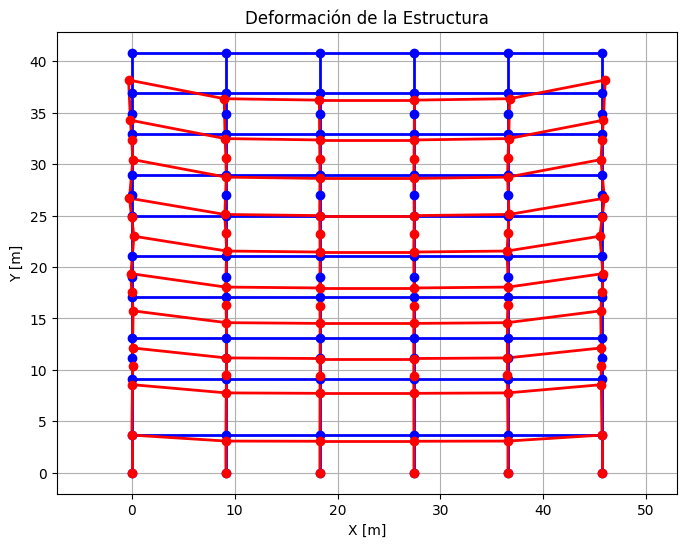

--------------------------------------------
Node 1 at [0. 0.]
Indices en matriz global: [0 1 2]
Carga nodal: [18.46164673  0.          0.        ]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 2 at [9.14 0.  ]
Indices en matriz global: [3 4 5]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 3 at [18.28  0.  ]
Indices en matriz global: [6 7 8]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [27.42  0.  ]
Indices en matriz global: [ 9 10 11]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 5 at [36.56  0.  ]
Indices en matriz global: [12 13 14]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
-----------

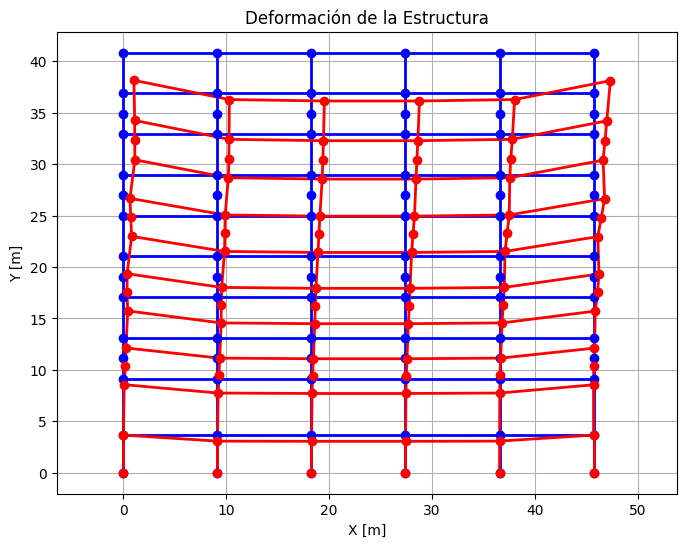

--------------------------------------------
Node 1 at [0. 0.]
Indices en matriz global: [0 1 2]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 2 at [9.14 0.  ]
Indices en matriz global: [3 4 5]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 3 at [18.28  0.  ]
Indices en matriz global: [6 7 8]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [27.42  0.  ]
Indices en matriz global: [ 9 10 11]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 5 at [36.56  0.  ]
Indices en matriz global: [12 13 14]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------

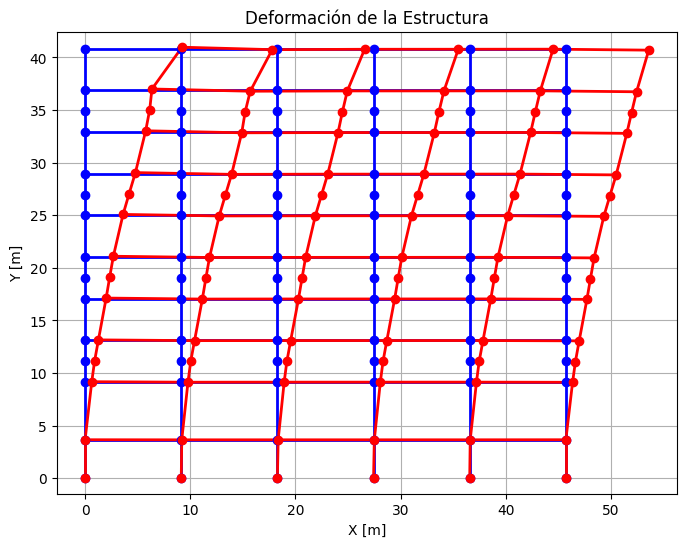

In [11]:

for caso in range(1, 4):
    
    nodos=crear_nodos(caso)
    elementos = crear_elementos(nodos,dx)
    nDoF_total = len(nodos) * globalParameters['nDoF']
    K_global = np.zeros((nDoF_total, nDoF_total))

    # Agregar cada elemento en la matriz global
    for elemento in elementos:
        dofs = np.hstack([elemento.node_i.idx, elemento.node_j.idx])
        for i in range(6):
            for j in range(6):
                K_global[dofs[i], dofs[j]] += elemento.k_global[i, j]

    solver = StructureSolver(nodos, K_global, globalParameters['nDoF'])

    # Obtener resultados
    desplazamientos = solver.get_displacements()
    reacciones = solver.get_reactions()

    # Mostrar resultados
    solver.resumen()
    fig, ax = plt.subplots(figsize=(8, 6))

    # Aplicar factor de escala a la deformación
    if caso != 3:
        scale_factor = 1000
    else:
        scale_factor = 10  # Ajusta este valor para visualizar mejor la deformación

    # Graficar las barras originales
    for elem in elementos:
        ax = elem.plotElement(ax=ax, color='b', text=False)

    # Graficar las barras deformadas
    plot_deformed_elements(elementos, ax=ax, scale_factor=scale_factor)

    # Graficar los nodos originales
    for nodo in nodos:
        ax.plot(nodo.coordenadas[0], nodo.coordenadas[1], 'bo')  # Nodos originales en azul

    # Graficar los nodos deformados
    for i, nodo in enumerate(nodos):
        # Aquí calculamos la deformación para cada nodo
        delta_x = desplazamientos[i * 3]  # Suponiendo que desplazamientos[i*3] es el desplazamiento en X
        delta_y = desplazamientos[i * 3 + 1]  # Suponiendo que desplazamientos[i*3+1] es el desplazamiento en Y
        
        # Calculamos la posición deformada (sin escala aún)
        nodo_deformado = nodo.coordenadas + np.array([delta_x, delta_y])

        # Aplicamos el factor de escala solo para la visualización
        nodo_deformado_scaled = nodo.coordenadas + np.array([delta_x, delta_y]) * scale_factor

        # Graficamos los nodos deformados en rojo
        ax.plot(nodo_deformado_scaled[0], nodo_deformado_scaled[1], 'ro')  # Nodos deformados en rojo

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title('Deformación de la Estructura')
    ax.grid(True)
    ax.axis('equal')
    plt.show()

**Here are the answers to question 4 of the homework:**


Modeling panel zones is a very useful tool for analyzing structural responses and evaluating how the structure will behave under certain loads, as well as understanding how changes in these loads affect the structure. Panel zones impact the stiffness, strength, and deformation capacity of beam-column elements. Failing to consider panel zones may lead to structural failures and yield results that could compromise safety in the design. Proper modeling of panel zones enables realistic simulation of load transfer, improving the prediction of structural behavior under various load types, including live loads, dead loads, rain, wind, snow, earthquakes, and other dynamic loads.


Then, regarding the structural deformations (i), it can be observed that in **Case 1**, the structure compresses downward. This behavior is understandable since the loads applied in this scenario are only the live loads and self-weight, resulting exclusively in vertical forces pushing downward on the structure. In **Case 2**, the deformation appears similar to the first case but includes more horizontal displacement, as a horizontal distributed load is introduced at the sides of the building. Finally, in **Case 3**, the structure noticeably deforms toward one side due to the triangular distributed load, which creates a greater horizontal force and therefore results in significant lateral deformation. 

In all cases, the structure compresses downward; however, horizontal loads additionally influence the deformation in cases 2 and 3. For visualization purposes, the deformation in **Cases 1 and 2** was amplified by a factor of 1000, while **Case 3** was amplified by a factor of 50, given that the horizontal deformation would not otherwise fit within the diagram.


Aqui va corte axial y momento

Finally, regarding the reactions (v), we can observe that in **Case 1**, vertical loads clearly dominate, as the structure is subjected only to live loads and self-weight. It is also noticeable that the intermediate supports receive most of the load transferred from the structure.

In **Case 2**, horizontal reactions become more significant due to the presence of lateral loads acting upon the structure. Vertical reactions remain similar to those in Case 1, although slightly increased.

In **Case 3**, horizontal reactions increase significantly because of the triangularly distributed load, which generates a strong lateral thrust. Additionally, vertical reactions rise compared to the previous two cases, especially at the central supports.

From the analysis of these reactions, we can conclude that **Case 3** is the most critical scenario, with the highest structural demands. This translates into greater risk if these conditions are not properly considered in the structural design.